In [1]:
# Libs
import os
import sys
import math
import random
import time
from datetime import datetime
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import ipdb

# Own modules
import preprocess
import prepare_input
import train_variants
import net
from deformations import elastically_deform_image_2d
import progress


# Constants
SIZE = 512

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
# Helper functions
def relPath(dir):
    "Returns path of directory relative to the executable"
    return os.path.join(os.getcwd(), dir)

In [3]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, threshold = roc_curve(labels, predictions)
    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    #plt.xlim([-0.5,20])
    #plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

Preprocessing...
Preparing input...
Input was already prepared
INFO:tensorflow:Restoring parameters from /Volumes/Data/ge0ra/Documents/Cours/Master/_MSc_TB/Source_code/tbcnn/checkpoints/model.ckpt
{'logits': array([[-4.402979 ,  2.2872999]], dtype=float32), 'probabilities': array([[0.00124139, 0.99875855]], dtype=float32), 'classes': array([1])}
{'logits': array([[-7.0852966,  6.710905 ]], dtype=float32), 'probabilities': array([[1.0194954e-06, 9.9999893e-01]], dtype=float32), 'classes': array([1])}
{'logits': array([[-9.797364,  8.058426]], dtype=float32), 'probabilities': array([[1.759257e-08, 1.000000e+00]], dtype=float32), 'classes': array([1])}
{'logits': array([[-5.550812 ,  3.8943815]], dtype=float32), 'probabilities': array([[7.9062462e-05, 9.9992096e-01]], dtype=float32), 'classes': array([1])}
{'logits': array([[-2.3930788,  1.2299645]], dtype=float32), 'probabilities': array([[0.02600687, 0.97399306]], dtype=float32), 'classes': array([1])}
{'logits': array([[-7.4160414,  7.

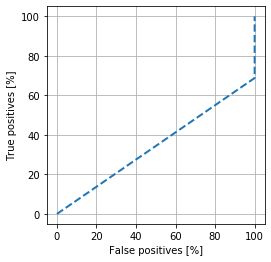

In [4]:
# Crop and resize images
# This expects the images to be saved in the data folder
# Extract 1/4 more for cropping augmentation
print('Preprocessing...')
preprocess.preprocess(relPath('data'), relPath('preprocessed'), size=int(SIZE*1.1))

# Prepare input: convert to float with unit variance and zero mean,
# extract labels and save everything as a big numpy array to be used for training
print('Preparing input...')
prepare_input.prepare(relPath('preprocessed'), relPath('input'))

# Load data
test_images = np.load(relPath('input') + '.npy', mmap_mode='r')
test_labels = np.load(relPath('input') + '_labels.npy', mmap_mode='r')

# Create training and test sets
#training, test = train_variants.split_train_and_test(images, labels)
#test_images, test_labels = test

# Crop center from test images
border = (test_images.shape[1] - SIZE) // 2
test_images = test_images[:,border:border+SIZE, border:border+SIZE]

run_name = datetime.now().strftime(r'%Y-%m-%d_%H:%M')

# Create network
inp_var, labels_var, output = net.generate_network(SIZE)
error_fn, train_fn, metrics = net.generate_functions(inp_var, labels_var, output)

config = tf.ConfigProto()
#config.gpu_options.allow_growth = True

with tf.Session() as sess:

    # Restore all the variables.
    saver = tf.train.Saver()
    currentDirectory = os.getcwd()
    saver.restore(sess, currentDirectory + "/checkpoints/model.ckpt")

    # Initialize accuracy calculation
    sess.run(tf.local_variables_initializer())

    # Get needed functions
    accuracy_fn, accuracy_update = metrics['accuracy']
    auc_fn, auc_update = metrics['AUC']
    #fp_fn, fp_update = metrics['fp']
    #tp_fn, tp_update = metrics['tp']
    computed_probabilities = []
    computed_logits = []
    computed_classes = []
    labels = []
    # Accuracy on test
    for ti, (img, lab) in enumerate(zip(test_images, test_labels)):
        labels.append(lab)
        print(sess.run(output, {
            'input:0': img.reshape(1, SIZE, SIZE, -1),
            'labels:0': [lab],
        }))

        computed_classes.append(sess.run(output['classes'][0], {
            'input:0': img.reshape(1, SIZE, SIZE, -1),
            'labels:0': [lab],
        }))

        computed_probabilities.append(max(sess.run(output['probabilities'][:,1], {
            'input:0': img.reshape(1, SIZE, SIZE, -1),
            'labels:0': [lab],
        })))

        sess.run([accuracy_update, auc_update], {
            'input:0': img.reshape(1, SIZE, SIZE, -1),
            'labels:0': [lab],
        })
        
        print('Test image {} / {}'.format(ti + 1, len(test_images)), end='\r')
    
    # Compute test metrics
    test_accuracy = sess.run(accuracy_fn)
    test_auc = sess.run(auc_fn)
    #test_fp = sess.run(fp_fn)
    #test_tp = sess.run(tp_fn)

    plot_roc("Test Baseline", test_labels, computed_classes, color=colors[0], linestyle='--')
    print(labels)
    print(computed_classes)
    print(computed_probabilities)
    # Print progress
    print(
        'Accuracy: {:>5.3f} | AUC: {:>5.3f}'
            .format(test_accuracy, test_auc)
    )